In [1]:
import os
import sys
from datetime import datetime
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import importlib
import math
import json
import matplotlib.patches as patches

##
matplotlib.rcParams['pdf.fonttype'] = 42

## Helpful locations which are assumed to already exist
work_dir = f"/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Yuanyuan/Project/BGa/results/fig5" 
data_dir = f"/allen/programs/celltypes/workgroups/rnaseqanalysis/hct_ux3_cellxgene/anndata_080/BasalGanglia/Astro"
os.chdir(work_dir)


/home/yuanyuan.fu/bin/miniconda3/envs/iterative_scANVI_May9/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/yuanyuan.fu/bin/miniconda3/envs/iterative_scANVI_May9/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/yuanyuan.fu/bin/miniconda3/envs/iterative_scANVI_May9/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/yuanyuan.fu/bin/miniconda3/envs/iterative_scANVI_May9/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/

In [3]:
adata = sc.read_h5ad(data_dir + "/HMBA_human_Astro_preprint_19clusters.h5ad")

target_clusters = ["h-14", "h-31", "h-7"]
adata_str = adata[adata.obs["cluster"].isin(target_clusters)].copy()

adata_str.obs["cluster"] = pd.Categorical(
    adata_str.obs["cluster"],
    categories=target_clusters,
    ordered=True
)

In [3]:
adata_str.obs['cluster'].value_counts()

cluster
h-14    58596
h-31     3350
h-7      1893
Name: count, dtype: int64

In [19]:
print(1893/(58596+3350+1893))
print(3350/(58596+3350+1893))
print(58596/(58596+3350+1893))

0.029652720124062094
0.05247575933206974
0.9178715205438681


### regional composition per cluster

In [ ]:
from typing import Optional, Dict, Sequence

def compute_region_composition(
    adata,
    *,
    donor_key: str = "donor_id",
    cluster_key: str = "Cluster",
    region_key: str = "anatomical_region_merged",
    normalize: bool = True
) -> pd.DataFrame:
    """
    Compute region composition (count or proportion) inside each donor × cluster.

    Parameters
    ----------
    adata : AnnData
    donor_key : str
        Column in .obs that encodes donor IDs.
    cluster_key : str
        Column in .obs that encodes the 3 astro subgroups (clusters).
    region_key : str
        Column in .obs that encodes anatomical regions.
    normalize : bool
        If True, return proportions within each (donor, cluster); otherwise counts.

    Returns
    -------
    tidy : pd.DataFrame
        Columns: [donor_key, cluster_key, region_key, 'n', 'prop']
        'prop' is present only when normalize=True.
    """
    obs = adata.obs[[donor_key, cluster_key, region_key]].copy()

    # Count cells
    tidy = (
        obs.groupby([donor_key, cluster_key, region_key])
           .size()
           .rename("n")
           .reset_index()
    )

    # Ensure all donor/cluster/region combinations exist (fill 0 for missing)
    donors   = obs[donor_key].unique()
    clusters = obs[cluster_key].unique()
    regions  = obs[region_key].unique()
    full_index = pd.MultiIndex.from_product(
        [donors, clusters, regions],
        names=[donor_key, cluster_key, region_key]
    )
    tidy = (
        tidy.set_index([donor_key, cluster_key, region_key])
            .reindex(full_index, fill_value=0)
            .reset_index()
    )

    if normalize:
        group_sum = tidy.groupby([donor_key, cluster_key])["n"].transform("sum")
        tidy["prop"] = tidy["n"] / group_sum
        tidy["prop"] = tidy["prop"].where(group_sum > 0, np.nan)

    return tidy


In [ ]:
tidy = compute_region_composition(
    adata_str,
    donor_key="donor_id",
    cluster_key="Cluster",
    region_key="anatomical_region_merged",
    normalize=True  
)

In [ ]:
from typing import List, Optional
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


def plot_cluster_region_boxplot(
    tidy_df: pd.DataFrame,
    cluster: str,
    figsize: tuple = (8, 4),
    region_order: Optional[List[str]] = None,
    color_palette: str = "Set2",
    box_width: float = 0.6,
    save_path: Optional[str] = None
):
    """
    Plot region-wise composition (per donor) in a given astrocyte cluster using boxplot + stripplot.

    Parameters
    ----------
    tidy_df : pd.DataFrame
        The output DataFrame from compute_region_composition.
    cluster : str
        Cluster name to subset and plot (e.g., 'Human-7').
    figsize : tuple
        Size of the output plot.
    region_order : list of str, optional
        Custom order for anatomical regions.
    color_palette : str
        Color palette used for boxplot.
    box_width : float
        Width of each box in the boxplot (default 0.6).
    save_path : str, optional
        If specified, the figure will be saved to this path (e.g. 'plot.pdf').
    """
    df = tidy_df[tidy_df["Cluster"] == cluster].copy()

    if region_order is None:
        region_order = df["anatomical_region_merged"].unique().tolist()

    plt.figure(figsize=figsize)

    sns.boxplot(
        data=df,
        x="anatomical_region_merged",
        y="prop",
        hue=None,
        palette=color_palette,
        order=region_order,
        showfliers=False,
        width=box_width
    )

    sns.stripplot(
        data=df,
        x="anatomical_region_merged",
        y="prop",
        hue="donor_id",
        dodge=False,
        size=5,
        jitter=True,
        alpha=0.7,
        order=region_order,
        palette="dark"
    )

    plt.title(f"Regional distribution of {cluster} by donor ")
    plt.ylabel("Proportion")
    plt.xlabel("Region")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.legend(
        bbox_to_anchor=(0.5, -0.1),
        loc="upper center",
        ncol=4,
        title="donor_id",
        fontsize="small",
        title_fontsize="small",
        frameon=False
    )

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=400, bbox_inches="tight")
        plt.close()
    else:
        plt.show()


In [ ]:
plot_cluster_region_boxplot(
    tidy,
    cluster="Human-14",
    box_width=0.6,
    figsize=(5.5, 3),
    region_order=["Ca", "Pu", "NAC",  "Eca", "GPe", "GPi", "VeP", "SN–VTA", "STH"]
)

plot_cluster_region_boxplot(
    tidy,
    cluster="Human-31",
    box_width=0.6,
    figsize=(5.5, 3),
    region_order=["Ca", "Pu", "NAC",  "Eca", "GPe", "GPi", "VeP", "SN–VTA", "STH"]
)

plot_cluster_region_boxplot(
    tidy,
    cluster="Human-7",
    box_width=0.6,
    figsize=(5.5, 3),
    region_order=["Ca", "Pu", "NAC",  "Eca", "GPe", "GPi", "VeP", "SN–VTA", "STH"]
)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import mannwhitneyu, ttest_ind
from typing import List, Optional

def pval_to_star(p: float) -> str:
    """Convert p-value to significance stars."""
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'n.s.'

def plot_cluster_region_boxplot(
    tidy_df: pd.DataFrame,
    cluster: str,
    figsize: tuple = (8, 4),
    region_order: Optional[List[str]] = None,
    color_palette: str = "Set2",
    box_width: float = 0.6,
    save_path: Optional[str] = None,
    highlight_regions: Optional[List[str]] = None,
    stat_test: str = "mannwhitney",
    show_star: bool = True
):
    """
    Plot region-wise composition (per donor) in a given astrocyte cluster using boxplot + stripplot.
    Adds pairwise significance annotations (p-values or stars) between specified regions.

    Parameters
    ----------
    tidy_df : pd.DataFrame
        Output from compute_region_composition.
    cluster : str
        Cluster name to subset (e.g., 'Human-14').
    figsize : tuple
        Figure size.
    region_order : list of str, optional
        Region display order.
    color_palette : str
        Color palette for boxplot.
    box_width : float
        Boxplot width.
    save_path : str, optional
        If provided, saves the figure to this path.
    highlight_regions : list of str
        Region names to test pairwise significance (e.g. ['Ca', 'Pu', 'NAC']).
    stat_test : str
        'mannwhitney' or 'ttest'.
    show_star : bool
        Whether to display p-values as stars (*, **, ***) or raw numbers.
    """
    df = tidy_df[tidy_df["Cluster"] == cluster].copy()

    if region_order is None:
        region_order = df["anatomical_region_merged"].unique().tolist()

    plt.figure(figsize=figsize)

    sns.boxplot(
        data=df,
        x="anatomical_region_merged",
        y="prop",
        palette=color_palette,
        order=region_order,
        showfliers=False,
        width=box_width
    )

    sns.stripplot(
        data=df,
        x="anatomical_region_merged",
        y="prop",
        hue="donor_id",
        dodge=False,
        size=5,
        jitter=True,
        alpha=0.7,
        order=region_order,
        palette="dark"
    )

    plt.title(f"Regional distribution of {cluster} by donor")
    plt.ylabel("Proportion")
    plt.xlabel("Region")
    plt.xticks(rotation=45)

    # ==== Significance annotation ====
    if highlight_regions:
        pairs = list(combinations(highlight_regions, 2))
        y_max_data = df["prop"].max()
        h = 0.05  # base height between annotation lines
        y_upper = min(1.05, y_max_data + h * (len(pairs) + 1))
        plt.ylim(0, y_upper)

        for i, (r1, r2) in enumerate(pairs):
            vals1 = df[df["anatomical_region_merged"] == r1]["prop"]
            vals2 = df[df["anatomical_region_merged"] == r2]["prop"]

            if stat_test == "mannwhitney":
                _, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
            elif stat_test == "ttest":
                _, p = ttest_ind(vals1, vals2, equal_var=False)
            else:
                raise ValueError("stat_test must be 'mannwhitney' or 'ttest'")

            x1, x2 = region_order.index(r1), region_order.index(r2)
            x_center = (x1 + x2) / 2
            y = y_max_data + h * (i + 1)

            # draw the connecting line
            bar_x = [x1, x1, x2, x2]
            bar_y = [y - h * 0.2, y, y, y - h * 0.2]
            plt.plot(bar_x, bar_y, c='k', lw=1, clip_on=False)

            # label with either stars or p-value
            label = pval_to_star(p) if show_star else f"p={p:.3g}"
            plt.text(x_center, y + 0.005, label, ha='center', va='bottom', fontsize=8)

    else:
        plt.ylim(0, 1.05)

    plt.legend(
        bbox_to_anchor=(0.5, -0.1),
        loc="upper center",
        ncol=4,
        title="donor_id",
        fontsize="small",
        title_fontsize="small",
        frameon=False
    )
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=400, bbox_inches="tight")
        plt.close()
    else:
        plt.show()


In [ ]:
plot_cluster_region_boxplot(
    tidy,
    cluster="Human-14",
    box_width=0.6,
    figsize=(5.5, 5),
    region_order=["Ca", "Pu", "NAC", "Eca", "GPe", "GPi", "VeP", "SN–VTA", "STH"],
    highlight_regions=["Ca", "Pu", "NAC"],
    stat_test="mannwhitney",
    show_star=False # if false -> p vaules not star*
)


In [ ]:
def plot_cluster_region_boxplot(
    tidy_df: pd.DataFrame,
    cluster: str,
    figsize: tuple = (8, 4),
    region_order: Optional[List[str]] = None,
    color_palette: str = "Set2",
    box_width: float = 0.6,
    save_path: Optional[str] = None,
    highlight_regions: Optional[List[str]] = None,
    stat_test: str = "mannwhitney",
    show_star: bool = True,
    min_n_per_group: int = 2
):
    """
    Enhanced boxplot with statistical annotations and robust NaN-safe handling.
    Skips comparisons with insufficient data or constant values, and prints out reasons.
    """
    df = tidy_df[tidy_df["Cluster"] == cluster].copy()

    if region_order is None:
        region_order = df["anatomical_region_merged"].unique().tolist()

    plt.figure(figsize=figsize)

    sns.boxplot(
        data=df,
        x="anatomical_region_merged",
        y="prop",
        palette=color_palette,
        order=region_order,
        showfliers=False,
        width=box_width
    )

    sns.stripplot(
        data=df,
        x="anatomical_region_merged",
        y="prop",
        hue="donor_id",
        dodge=False,
        size=5,
        jitter=True,
        alpha=0.7,
        order=region_order,
        palette="dark"
    )

    plt.title(f"{cluster}") #f"Regional distribution of {cluster} by donor"
    plt.ylabel("Proportion")
    plt.xlabel("Region")
    plt.xticks(rotation=45)

    # ==== Significance annotation ====
    if highlight_regions:
        pairs = list(combinations(highlight_regions, 2))
        y_max_data = df["prop"].max()
        h = 0.05
        y_upper = min(1.05, y_max_data + h * (len(pairs) + 1))
        plt.ylim(0, y_upper)

        for i, (r1, r2) in enumerate(pairs):
            vals1 = df[df["anatomical_region_merged"] == r1]["prop"].dropna()
            vals2 = df[df["anatomical_region_merged"] == r2]["prop"].dropna()

            reason = None
            if len(vals1) < min_n_per_group:
                reason = f"{r1} has insufficient data (n={len(vals1)})"
            elif len(vals2) < min_n_per_group:
                reason = f"{r2} has insufficient data (n={len(vals2)})"
            elif vals1.nunique() == 1 and vals2.nunique() == 1 and vals1.iloc[0] == vals2.iloc[0]:
                reason = f"{r1} and {r2} both constant ({vals1.iloc[0]})"

            if reason:
                print(f"⚠️ Skipping {r1} vs {r2}: {reason}")
                print(f"  → {r1} values: {vals1.values}")
                print(f"  → {r2} values: {vals2.values}")
                continue

            # valid comparison
            if stat_test == "mannwhitney":
                _, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
            elif stat_test == "ttest":
                _, p = ttest_ind(vals1, vals2, equal_var=False)
            else:
                raise ValueError("stat_test must be 'mannwhitney' or 'ttest'")

            x1, x2 = region_order.index(r1), region_order.index(r2)
            x_center = (x1 + x2) / 2
            y = y_max_data + h * (i + 1)

            # draw line
            bar_x = [x1, x1, x2, x2]
            bar_y = [y - h * 0.2, y, y, y - h * 0.2]
            plt.plot(bar_x, bar_y, c='k', lw=1, clip_on=False)

            # label
            label = pval_to_star(p) if show_star else f"p={p:.3g}"
            plt.text(x_center, y + 0.005, label, ha='center', va='bottom', fontsize=8)

    else:
        plt.ylim(0, 1.05)

    plt.legend(
        bbox_to_anchor=(0.5, -0.1),
        loc="upper center",
        ncol=4,
        title="donor_id",
        fontsize="small",
        title_fontsize="small",
        frameon=False
    )
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=400, bbox_inches="tight")
        plt.close()
    else:
        plt.show()


In [ ]:
plot_cluster_region_boxplot(
    tidy,
    cluster="Human-14",
    figsize=(5.5, 5),
    region_order=["Ca", "Pu", "NAC", "Eca", "GPe", "GPi", "VeP", "SN–VTA", "STH"],
    highlight_regions=["Ca", "Pu", "NAC"],
    stat_test="mannwhitney",
    show_star=False  # p value
)

plot_cluster_region_boxplot(
    tidy,
    cluster="Human-14",
    figsize=(5.5, 5),
    region_order=["Ca", "Pu", "NAC", "Eca", "GPe", "GPi", "VeP", "SN–VTA", "STH"],
    highlight_regions=["Ca", "Pu", "NAC"],
    stat_test="mannwhitney",
    show_star=True  # p value
)


In [ ]:
plot_cluster_region_boxplot(
    tidy,
    cluster="Human-7",
    figsize=(5.5, 5),
    region_order=["Ca", "Pu", "NAC", "Eca", "GPe", "GPi", "VeP", "SN–VTA", "STH"],
    highlight_regions=["Ca", "Pu", "NAC"],
    stat_test="mannwhitney",
    show_star=False  # p value
)

plot_cluster_region_boxplot(
    tidy,
    cluster="Human-7",
    figsize=(5.5, 5),
    region_order=["Ca", "Pu", "NAC", "Eca", "GPe", "GPi", "VeP", "SN–VTA", "STH"],
    highlight_regions=["Ca", "Pu", "NAC"],
    stat_test="mannwhitney",
    show_star=True  # p value
)

In [ ]:
plot_cluster_region_boxplot(
    tidy,
    cluster="Human-31",
    figsize=(5.5, 5),
    region_order=["Ca", "Pu", "NAC", "Eca", "GPe", "GPi", "VeP", "SN–VTA", "STH"],
    highlight_regions=["Ca", "Pu", "NAC"],
    stat_test="mannwhitney",
    show_star=False  # p value
)

plot_cluster_region_boxplot(
    tidy,
    cluster="Human-31",
    figsize=(5.5, 5),
    region_order=["Ca", "Pu", "NAC", "Eca", "GPe", "GPi", "VeP", "SN–VTA", "STH"],
    highlight_regions=["Ca", "Pu", "NAC"],
    stat_test="mannwhitney",
    show_star=True  # p value
)

plot_cluster_region_boxplot(
    tidy,
    cluster="Human-31",
    figsize=(5.5, 5),
    region_order=["Ca", "Pu", "NAC", "Eca", "GPe", "GPi", "VeP", "SN–VTA", "STH"],
    highlight_regions=["Ca", "Pu", "NAC"],
    stat_test="mannwhitney",
    show_star=True,  # p value
    save_path="boxplot_Human-31_region_composition_per_donor_withSign.pdf",
)


#### look closer for Ca in h-7

In [ ]:
plot_cluster_region_boxplot(
    tidy,
    cluster="Human-14",
    box_width=0.6,
    figsize=(5.5, 3),
    save_path="boxplot_Human-14_region_composition_per_donor.pdf",
    region_order=["Ca", "Pu", "NAC",  "Eca", "GPe", "GPi", "VeP", "SN–VTA", "STH"]
)

plot_cluster_region_boxplot(
    tidy,
    cluster="Human-7",
    box_width=0.6,
    figsize=(5.5, 3),
    save_path="boxplot_Human-7_region_composition_per_donor.pdf",
    region_order=["Ca", "Pu", "NAC",  "Eca", "GPe", "GPi", "VeP", "SN–VTA", "STH"]
)

plot_cluster_region_boxplot(
    tidy,
    cluster="Human-31",
    box_width=0.6,
    figsize=(5.5, 3),
    save_path="boxplot_Human-31_region_composition_per_donor.pdf",
    region_order=["Ca", "Pu", "NAC",  "Eca", "GPe", "GPi", "VeP", "SN–VTA", "STH"]
)

In [ ]:
def assign_region_for_plotting(adata):
    """
    Create a new obs field 'region_for_plotting' that uses:
    - fine Ca subdivisions if available (CaH, CaB, CaT)
    - otherwise uses the merged anatomical_region_merged
    """
    ca_subregions = {'CaH', 'CaB', 'CaT'}

    # Start with the merged region
    region_plot = adata.obs["anatomical_region_merged"].astype(str).copy()

    # Replace 'Ca' with fine-grained Ca subregions if available
    is_ca = region_plot == "Ca"
    is_ca_fine = adata.obs["anatomical_region"].astype(str).isin(ca_subregions)

    region_plot[is_ca & is_ca_fine] = adata.obs["anatomical_region"]

    # Assign back to adata.obs
    adata.obs["region_for_plotting"] = region_plot

assign_region_for_plotting(adata_str)



adata_str.obs['anatomical_region_merged_copy'] = adata_str.obs['anatomical_region_merged'].copy()
adata_str.obs['anatomical_region_merged'] = adata_str.obs['region_for_plotting'].copy()



tidy2 = compute_region_composition(
    adata_str,
    donor_key="donor_id",
    cluster_key="Cluster",
    region_key="anatomical_region_merged",
    normalize=True 
)


In [ ]:
for cl in tidy2["Cluster"].unique():
    plot_cluster_region_boxplot(
        tidy2, 
        cluster=cl, 
        box_width=0.6,
        figsize=(5.5, 3),
        region_order=["CaH", 'CaB', 'CaT',  "Pu", "NAC","Eca", "GPe", "GPi", "VeP", "SN–VTA", "STH"]
    )


plot_cluster_region_boxplot(
    tidy2, 
    cluster="Human-7", 
    box_width=0.6,
    figsize=(5.5, 3),
    region_order=["CaH", 'CaB', 'CaT',  "Pu", "NAC","Eca", "GPe", "GPi", "VeP", "SN–VTA", "STH"],
    save_path="boxplot_Human-7_CaHBT-region_composition_per_donor.pdf",
)

adata_str.obs['anatomical_region_merged'] = adata_str.obs['anatomical_region_merged_copy'].copy()

### DEGs across clusters in GM STR

In [20]:
adata_str.obs.groupby(['cluster', 'donor_id']).size().unstack(fill_value=0)

donor_id,H18.30.001,H19.30.004,H20.30.001,H20.30.002,H21.30.004,H23.30.001,H24.30.001,H24.30.003,H24.30.004,H24.30.007
cluster,,,,,,,,,,
h-14,1916,2,2804,3516,7588,5560,11132,10281,8592,7205
h-7,64,0,72,183,210,207,186,421,337,213
h-31,23,0,2504,9,242,46,38,35,424,29


#### downsample per cluster per donor

In [21]:
from typing import Optional, List
from anndata import AnnData
import numpy as np
import pandas as pd

def downsample_per_cluster_donor(
    adata: AnnData,
    cluster_key: str = "Cluster",
    donor_key: str = "donor_id",
    max_cells_per_group: int = 50,
    clusters_to_include: Optional[List[str]] = None,
    require_shared_donors: bool = True,
    random_state: Optional[int] = None
) -> AnnData:
    """
    Downsample per (cluster × donor) to a maximum number of cells,
    with optional filtering to retain only donors shared across multiple clusters.
    Supports fixed random seed for reproducibility.

    Parameters
    ----------
    adata : AnnData
        Input AnnData object.
    cluster_key : str
        Column in .obs specifying clusters.
    donor_key : str
        Column in .obs specifying donor IDs.
    max_cells_per_group : int
        Maximum number of cells per (cluster × donor) group.
    clusters_to_include : list of str, optional
        Only retain these clusters if provided.
    require_shared_donors : bool
        If True, only keep donors that appear in ≥2 of the specified clusters.
    random_state : int, optional
        Seed for reproducible downsampling. If None, randomness is not fixed.

    Returns
    -------
    AnnData
        Downsampled AnnData object.
    """
    obs = adata.obs
    if clusters_to_include is not None:
        obs = obs[obs[cluster_key].isin(clusters_to_include)]

    # Identify donors present in ≥2 different clusters
    if require_shared_donors:
        donor_cluster_counts = obs.groupby(donor_key)[cluster_key].nunique()
        shared_donors = donor_cluster_counts[donor_cluster_counts >= 2].index.tolist()
        obs = obs[obs[donor_key].isin(shared_donors)]

    rng = np.random.default_rng(random_state)  # reproducible generator
    selected_indices = []

    for clus in obs[cluster_key].unique():
        clus_df = obs[obs[cluster_key] == clus]
        for donor in clus_df[donor_key].unique():
            donor_cells = clus_df[clus_df[donor_key] == donor].index.tolist()
            if len(donor_cells) <= max_cells_per_group:
                selected_indices.extend(donor_cells)
            else:
                sampled = rng.choice(donor_cells, size=max_cells_per_group, replace=False)
                selected_indices.extend(sampled)

    return adata[selected_indices].copy()


In [22]:
adata_str_down = downsample_per_cluster_donor(
    adata_str,
    cluster_key="cluster",
    donor_key="donor_id",
    max_cells_per_group=100,
    clusters_to_include=["h-14", "h-7",  "h-31"],
    require_shared_donors=True,
    random_state=123  # reproducible
)


In [23]:
adata_str_down.obs.groupby(['cluster', 'donor_id']).size().unstack(fill_value=0)


donor_id,H18.30.001,H20.30.001,H20.30.002,H21.30.004,H23.30.001,H24.30.001,H24.30.003,H24.30.004,H24.30.007
cluster,,,,,,,,,
h-14,100,100,100,100,100,100,100,100,100
h-7,64,72,100,100,100,100,100,100,100
h-31,23,100,9,100,46,38,35,100,29


#### scanpy DE test

In [24]:
sc.tl.rank_genes_groups(adata_str_down, "cluster", method="wilcoxon", corr_method = "benjamini-hochberg", pts=True, 
                        use_raw=False, reference="rest", key_added="Cluster_in_GM_STR") #https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.rank_genes_groups.html


print(adata_str_down.uns["Cluster_in_GM_STR"]["names"].dtype.names)
all_groups = adata_str_down.uns["Cluster_in_GM_STR"]["names"].dtype.names

df_all = pd.concat([
    sc.get.rank_genes_groups_df(adata_str_down, group=grp, key='Cluster_in_GM_STR').assign(group=grp)
    for grp in all_groups
])

display(df_all.head(30))
df_all.to_csv(work_dir + "/rank_genes_groups_3clusters_DEGs_in_GMstr.csv", index=False)

('h-14', 'h-7', 'h-31')


,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference,group
0,HPSE2,16.627317,3.443244,4.419453e-62,1.617564e-57,0.795556,0.526596,h-14
1,TRPM3,16.212444,3.019350,4.118555e-59,7.537161e-55,0.887778,0.630699,h-14
2,GRID2,14.800918,2.112101,1.444972e-49,1.762914e-45,0.921111,0.781915,h-14
3,CNTN1,13.558734,2.985533,7.033970e-42,6.436259e-38,0.678889,0.389818,h-14
4,TPD52L1,13.203554,2.086426,8.369161e-40,6.126393e-36,0.927778,0.737842,h-14
5,ALDH1A1,12.876632,2.985589,6.093782e-38,3.717309e-34,0.672222,0.351064,h-14
6,SLC39A11,12.345856,1.928974,5.128626e-35,2.681612e-31,0.826667,0.639058,h-14
7,PLCB1,11.969448,1.021505,5.136909e-33,2.089067e-29,0.948889,0.896657,h-14
8,EPHB1,11.880180,1.688916,1.500439e-32,5.491757e-29,0.841111,0.689210,h-14
9,LINC00299,11.484844,1.138587,1.572183e-30,5.231224e-27,0.947778,0.877660,h-14


#### markers for visulization

(129, 8)
Marker gene lists saved by clusters.


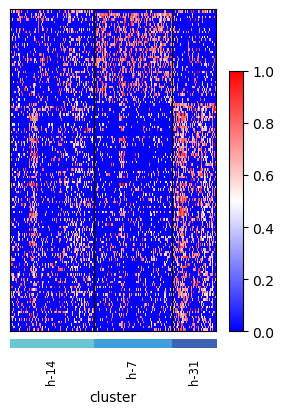

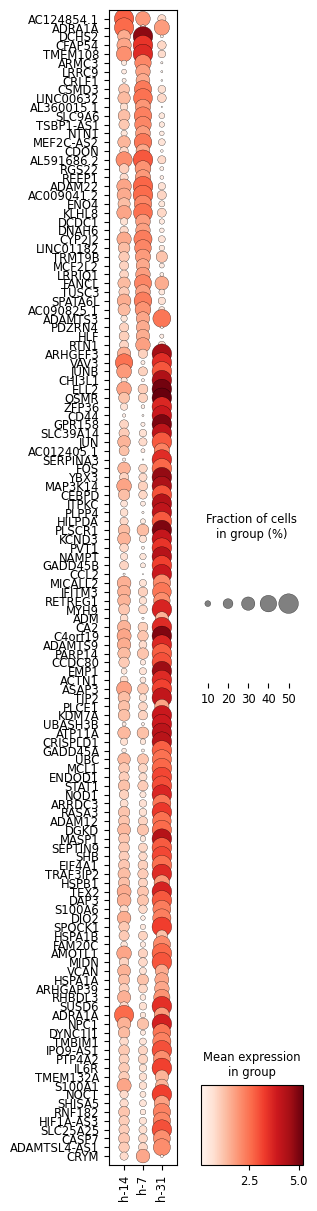

group
h-14     2
h-31    91
h-7     36
Name: names, dtype: int64


In [48]:
markers_df = df_all[
    (df_all['pvals_adj'] < 0.01) &                 
    (df_all['logfoldchanges'] > 1) &  # .abs() 
    (df_all['pct_nz_group'] > 0.3)  &  # >0.2
    ((df_all['pct_nz_group'] - df_all['pct_nz_reference']) > 0.15) & 
    (df_all['pct_nz_reference'] < 0.3)
]
print(markers_df.shape)

# Group marker genes by subGroup and save each list as a separate txt file
grouped = markers_df.groupby('group')['names']

#for group, gene_series in grouped:
#    gene_list = gene_series.unique()
#    file_path = os.path.join(work_dir, f"marker_genes_{group.replace(' ', '_')}.txt")
#    with open(file_path, 'w') as f:
#        for gene in gene_list:
#            f.write(f"{gene}\n")

print("Marker gene lists saved by clusters.")

marker_genes = markers_df['names'].tolist()
matplotlib.rcParams['pdf.fonttype'] = 42

sc.pl.heatmap(adata_str_down, 
              marker_genes, 
              groupby='cluster', 
              standard_scale='var',
              cmap='bwr',
              use_raw=False, 
              swap_axes=True,
              figsize=(3, 4.5),             
            #  save="astro_marker_heatmap.pdf" 
) 

sc.pl.dotplot(
    adata_str, # #not down-sampled h5ad
    var_names=marker_genes + ['CRYM'],
    groupby='cluster',
    use_raw=False,
    standard_scale='None',#'var',
    #cmap='bwr',
    figsize=(2.5, 15),
    dot_max=0.5,
    swap_axes=True,
)


print(markers_df.groupby('group')['names'].nunique())


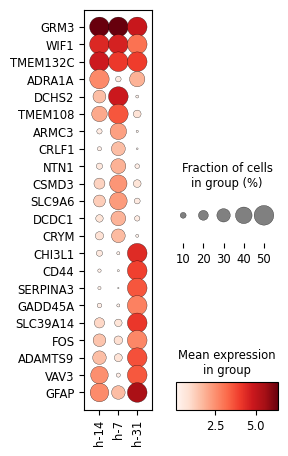

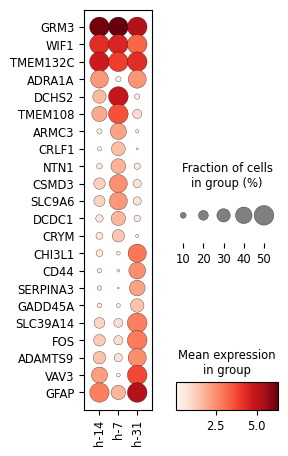

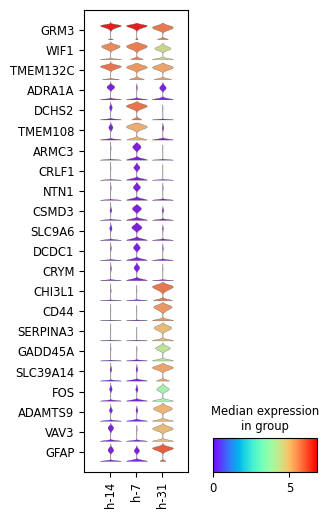

In [67]:
marker_to_show = ['GRM3', 'WIF1', 'TMEM132C', #'TNC', 'GFAP', 'DPP6'
                  'ADRA1A',
                  'DCHS2', 'TMEM108', 'ARMC3', 'CRLF1',  'NTN1', 'CSMD3', 'SLC9A6', 'DCDC1', 'CRYM', #lrrc9 not very much brain/neuronal-related.
                  'CHI3L1', 'CD44', 'SERPINA3', 'GADD45A', 'SLC39A14', 'FOS', 'ADAMTS9', 'VAV3', 'GFAP', #'STAT3',
                 ]

sc.pl.dotplot(
    adata_str, ##shown in not-down-sampled h5ad, although DEGs calculated against d.s.
    marker_to_show,
    groupby='cluster',
    use_raw=False,
    standard_scale='None',#'var',
    #cmap='bwr',
    figsize=(2.5, 5.2),
    dot_max=0.5,
    swap_axes=True,
)

sc.pl.dotplot(
    adata_str_down, ##shown in down-sampled h5ad, just checked if pattern robust or not.
    marker_to_show,
    groupby='cluster',
    use_raw=False,
    standard_scale='None',#'var',
    figsize=(2.5, 5.2),
    dot_max=0.5,
    swap_axes=True,
)

sc.pl.stacked_violin(
    adata_str, 
    marker_to_show, 
    groupby='cluster', 
    use_raw=False, 
    swap_axes=True, 
    figsize=(3,6),
    cmap='rainbow', #Blues
    dendrogram=False,
    save="Violinplot_of_GMSTRclusters-Astro-Markers_of_fig5.pdf",
)

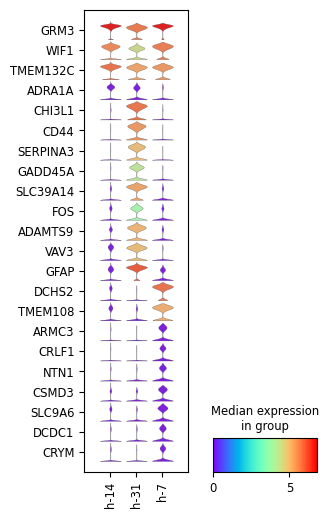

In [4]:
marker_to_show = ['GRM3', 'WIF1', 'TMEM132C', #'TNC', 'GFAP', 'DPP6'
                  'ADRA1A',
                  'CHI3L1', 'CD44', 'SERPINA3', 'GADD45A', 'SLC39A14', 'FOS', 'ADAMTS9', 'VAV3', 'GFAP', #'STAT3',
                  'DCHS2', 'TMEM108', 'ARMC3', 'CRLF1',  'NTN1', 'CSMD3', 'SLC9A6', 'DCDC1', 'CRYM', #lrrc9 not very much brain/neuronal-related.
                 ]

sc.pl.stacked_violin(
    adata_str, 
    marker_to_show, 
    groupby='cluster', 
    use_raw=False, 
    swap_axes=True, 
    figsize=(3,6),
    cmap='rainbow', #Blues
    dendrogram=False,
    save="Violinplot_of_GMSTRclusters-Astro-Markers_of_fig6.pdf",
)

#### markers expression pattern in whole BG taxonomy at Subclass level

In [4]:
data_dir = f"/allen/programs/celltypes/workgroups/rnaseqanalysis/hct_ux3_cellxgene/anndata_080/BasalGanglia/Astro/../BICAN-releases/final"
adata_bg = sc.read_h5ad(data_dir + "/Human_HMBA_basalganglia_AIT_pre-print.h5ad")

In [8]:
set(adata_bg.obs['donor_id'])

{'H18.30.001',
 'H19.30.004',
 'H20.30.001',
 'H20.30.002',
 'H21.30.004',
 'H23.30.001',
 'H24.30.001',
 'H24.30.003',
 'H24.30.004',
 'H24.30.007'}

In [4]:
# --- 1) Build the subClass order from display_order_group (unique, order-preserving)
adata_bg.obs['display_order_group'] = adata_bg.obs['display_order_group'].astype('category')
group_to_subclass = (
    adata_bg.obs[['display_order_group', 'Subclass']]
    .drop_duplicates()
    .set_index('display_order_group')['Subclass']
)

group_order = list(adata_bg.obs['display_order_group'].cat.categories)

subclass_order = []
seen = set()
for g in group_order:
    scname = group_to_subclass[g]
    if scname not in seen:
        subclass_order.append(scname)
        seen.add(scname)

# Keep only categories that actually exist in the object
present = pd.Index(adata_bg.obs['Subclass'].unique())
subclass_order = [c for c in subclass_order if c in present]
print(subclass_order)

# --- 2) Set subClass as ordered categorical by that order
adata_bg.obs['Subclass'] = pd.Categorical(adata_bg.obs['Subclass'],
                                          categories=subclass_order,
                                          ordered=True)


['Astrocyte', 'Ependymal', 'Microglia', 'Macrophage', 'Lymphocyte', 'Monocyte', 'Oligodendrocyte', 'OPC', 'COP', 'Endo', 'Pericyte', 'SMC', 'VLMC', 'F Glut', 'F M Glut', 'M Dopa', 'CN LAMP5-LHX6 GABA', 'CN ST18 GABA', 'STR SST-CHODL GABA', 'STR SST GABA', 'STR RSPO2 GABA', 'CN Cholinergic GABA', 'CN LAMP5-CXCL14 GABA', 'CN VIP GABA', 'CN LHX8 GABA', 'CN ONECUT1 GABA', 'F M GATA3 GABA', 'SN PAX7 GABA', 'F GABA', 'CN MEIS2 GABA', 'STR D1 MSN', 'STR D2 MSN', 'STR Hybrid MSN', 'OT Granular GABA', 'ACx MEIS2 GABA', 'CN GABA-Glut']


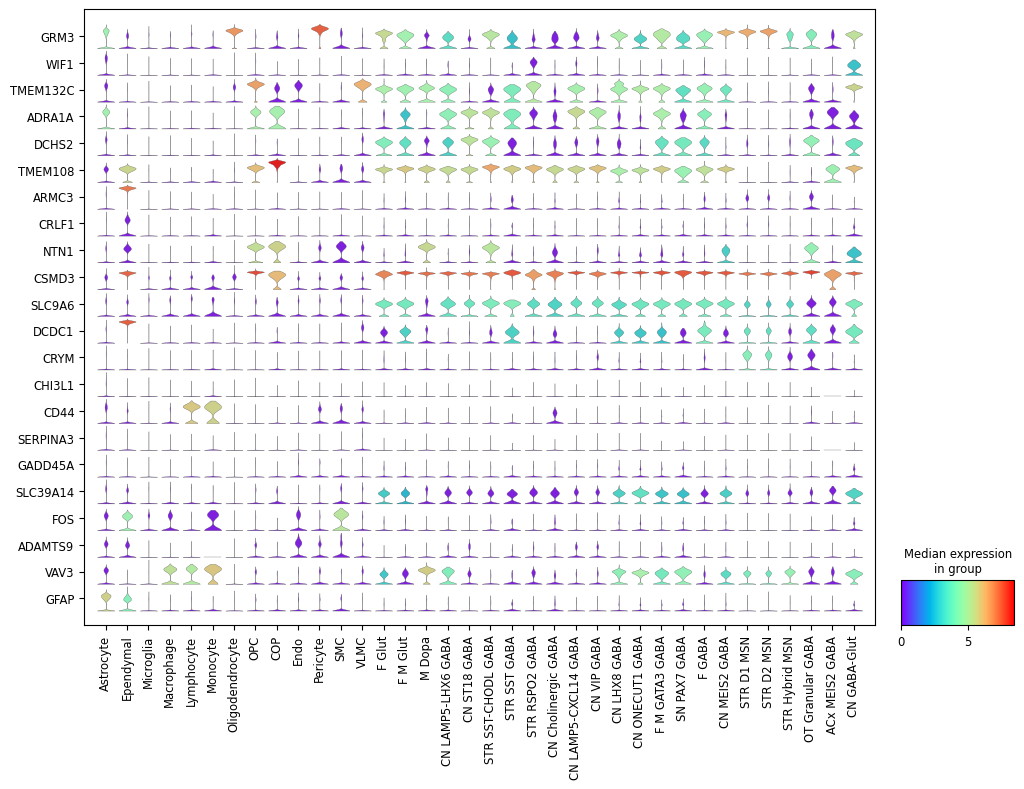

In [5]:
marker_to_show = ['GRM3', 'WIF1', 'TMEM132C', #'TNC', 'GFAP', 'DPP6'
                  'ADRA1A',
                  'DCHS2', 'TMEM108', 'ARMC3', 'CRLF1',  'NTN1', 'CSMD3', 'SLC9A6', 'DCDC1', 'CRYM', #lrrc9 not very much brain/neuronal-related.
                  'CHI3L1', 'CD44', 'SERPINA3', 'GADD45A', 'SLC39A14', 'FOS', 'ADAMTS9', 'VAV3', 'GFAP', #'STAT3',
                 ]

sc.pl.stacked_violin(
    adata_bg, 
    marker_to_show, 
    groupby='Subclass', 
    use_raw=False, 
    swap_axes=True, 
    figsize=(12,8),
    cmap='rainbow', #Blues
    dendrogram=False,
    save="Violinplot_of_GMSTRclusters-Astro-Markers_of_fig5_in_HMBAhumanBGTaxo.pdf"
)

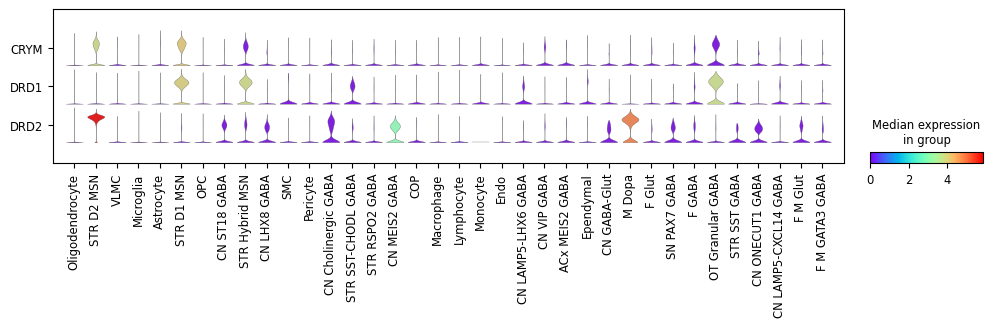

In [20]:
marker_to_show = ['CRYM', #lrrc9 not very much brain/neuronal-related.
                  'DRD1','DRD2', #'STAT3',
                 ]

sc.pl.stacked_violin(
    adata_bg, 
    marker_to_show, 
    groupby='Subclass', 
    use_raw=False, 
    swap_axes=True, 
    figsize=(12,2),
    cmap='rainbow', #Blues
    dendrogram=False,
    save="Violinplot_crym_of_fig6_in_HMBAhumanBGTaxo.pdf"
)

#### h-7 markers expression pattern in MSN+OT subClasses at Group level

In [6]:
target = ["STR D1 MSN", "STR D2 MSN", "STR Hybrid MSN", "OT Granular GABA"] #"STR D1D2 Hybrid MSN", 
adata_bg_target = adata_bg[adata_bg.obs["Subclass"].isin(target)]
adata_bg_target.shape


(450613, 36601)

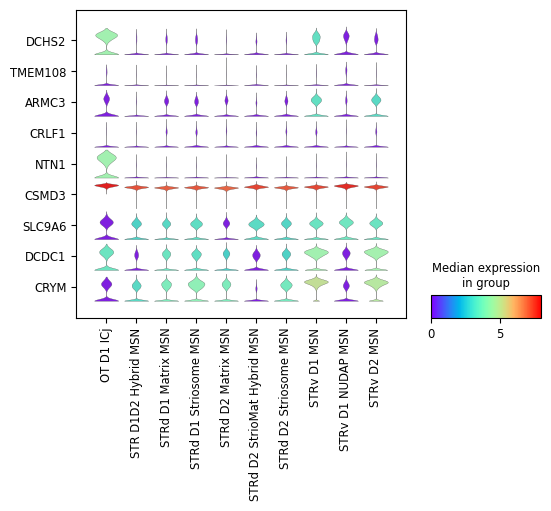

In [8]:
h_7_marker_to_show = ['DCHS2', 'TMEM108', 'ARMC3', 'CRLF1', 'NTN1', 'CSMD3', 'SLC9A6', 'DCDC1', 'CRYM'] #lrrc9 not very much brain/neuronal-related.
                

sc.pl.stacked_violin(
    adata_bg_target, 
    h_7_marker_to_show, 
    groupby='Group', 
    use_raw=False, 
    swap_axes=True, 
    figsize=(6,4),
    cmap='rainbow', #Blues
    dendrogram=False,
 #   save="Violinplot_of_GMSTRclusters-Astro-Markers_of_fig5_in_HMBAhumanBGTaxo.pdf"
)

In [9]:
set(adata_bg_target.obs['Group'])

{'OT D1 ICj',
 'STR D1D2 Hybrid MSN',
 'STRd D1 Matrix MSN',
 'STRd D1 Striosome MSN',
 'STRd D2 Matrix MSN',
 'STRd D2 StrioMat Hybrid MSN',
 'STRd D2 Striosome MSN',
 'STRv D1 MSN',
 'STRv D1 NUDAP MSN',
 'STRv D2 MSN'}

In [12]:
group_order = ['OT D1 ICj', 'STRv D1 MSN', 'STRv D2 MSN', 'STRv D1 NUDAP MSN', 'STR D1D2 Hybrid MSN', 'STRd D1 Matrix MSN', 'STRd D2 Matrix MSN', 'STRd D1 Striosome MSN', 'STRd D2 Striosome MSN', 'STRd D2 StrioMat Hybrid MSN']
adata_bg_target.obs['Group'] = pd.Categorical(adata_bg_target.obs['Group'],
                                              categories=group_order,
                                              ordered=True)

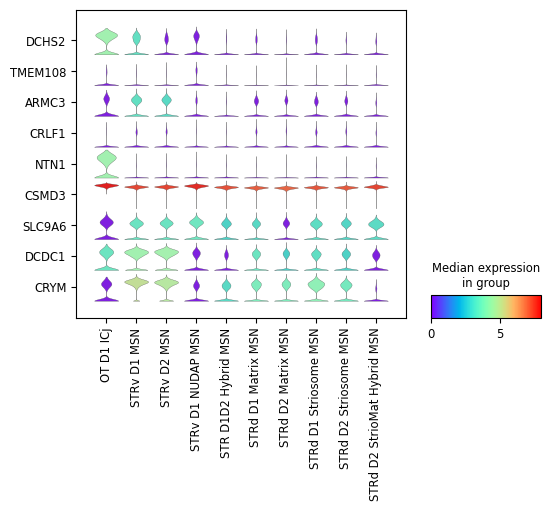

In [13]:
h_7_marker_to_show = ['DCHS2', 'TMEM108', 'ARMC3', 'CRLF1', 'NTN1', 'CSMD3', 'SLC9A6', 'DCDC1', 'CRYM'] #lrrc9 not very much brain/neuronal-related.
                

sc.pl.stacked_violin(
    adata_bg_target, 
    h_7_marker_to_show, 
    groupby='Group', 
    use_raw=False, 
    swap_axes=True, 
    figsize=(6,4),
    cmap='rainbow', #Blues
    dendrogram=False,
    save="Violinplot_of_h7cluster-Astro-Markers_of_fig5_in_HMBAhumanBGTaxoMSN.pdf"
)

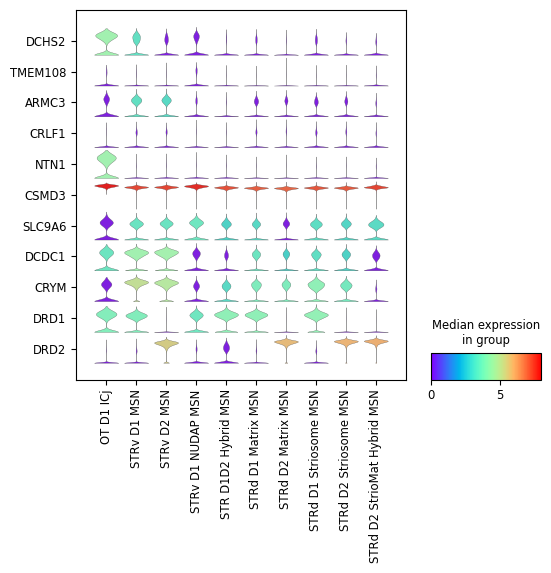

In [14]:
h_7_marker_to_show = ['DCHS2', 'TMEM108', 'ARMC3', 'CRLF1', 'NTN1', 'CSMD3', 'SLC9A6', 'DCDC1', 'CRYM', 'DRD1', 'DRD2'] #lrrc9 not very much brain/neuronal-related.
                

sc.pl.stacked_violin(
    adata_bg_target, 
    h_7_marker_to_show, 
    groupby='Group', 
    use_raw=False, 
    swap_axes=True, 
    figsize=(6,4.8),
    cmap='rainbow', #Blues
    dendrogram=False,
    save="Violinplot_of_h7cluster-Astro-Markers_of_fig5_in_HMBAhumanBGTaxoMSN222.pdf"
)

### cellchat h5ad

In [ ]:
adata = sc.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/hct_ux3_cellxgene/anndata_080/BasalGanglia/BICAN-releases/final/downsample/Human_downsampled_cluster_id_1k.h5ad")


target = ["Astrocyte", "STRd D1 Matrix MSN", "STRd D1 Striosome MSN", "STRd D2 Matrix MSN", "STRd D2 StrioMat Hybrid MSN", "STRd D2 Striosome MSN", "STRv D1 MSN", "STRv D2 MSN", "STRv D1 NUDAP MSN"] #"STR D1D2 Hybrid MSN", 
adata = adata[adata.obs["Group"].isin(target)]
adata.shape


In [ ]:
set(adata.obs["Group"])

In [ ]:
astro_clusters = ["Human-14", "Human-7", "Human-31"]

adata = adata[
    (adata.obs["Group"] != "Astrocyte") |  # keep STR MSNs
    (adata.obs["Cluster"].isin(astro_clusters))  # keep GM STR astro
].copy()

In [ ]:
def assign_Ident(row):
    if "Astrocyte" in row["Group"]:  # or use exact match: row["Group"] == "Astrocyte"
        return row["Cluster"]
    else:
        return row["Group"]

adata.obs["Ident_notes"] = adata.obs.apply(assign_Ident, axis=1)

rename_dict = {
    'Human-7':  'GM_STRv_astro',
    'Human-14': 'GM_STR_astro',
    'Human-31': 'GM_STRd_astro',
    'STRd D1 Matrix MSN': 'STRd MSN',
    'STRd D1 Striosome MSN': 'STRd MSN', 
    'STRd D2 Matrix MSN': 'STRd MSN', 
    'STRd D2 StrioMat Hybrid MSN': 'STRd MSN', 
    'STRd D2 Striosome MSN': 'STRd MSN', 
    'STRv D1 MSN': 'STRv MSN', 
    'STRv D2 MSN': 'STRv MSN', 
    'STRv D1 NUDAP MSN' : 'STRv MSN',
}

adata.obs['Ident_notes'] = adata.obs['Ident_notes'].map(rename_dict).fillna(adata.obs['Ident_notes'])

sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['Ident_notes'],
    frameon=False,
    ncols=1
)

In [ ]:
del adata.raw

In [ ]:
adata.write_h5ad(work_dir + "/STRastro-MSN_forCellchat2vd.h5ad") # for cellchat analysis, the h5ad is cluster-down-sampled.

### dotplot for NTN1-DCC in whole MSN+astro h5ad

In [3]:
#data_dir = f"/allen/programs/celltypes/workgroups/rnaseqanalysis/hct_ux3_cellxgene/anndata_080/BasalGanglia/Astro/../BICAN-releases/final"
#adata = sc.read_h5ad(data_dir + "/Human_HMBA_basalganglia_AIT_pre-print.h5ad")
adata_bg

AnnData object with n_obs × n_vars = 1034819 × 36601
    obs: 'Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster', 'cluster_id', 'cell_type_ontology_term', 'load_id', 'donor_id', 'assay', 'assay_ontology_term_id', 'organism', 'organism_ontology_term_id', 'development_stage', 'anatomical_region', 'anatomical_region_merged', 'anatomical_region_ontology_term_id', 'brain_region_ontology_term_id', 'self_reported_sex', 'self_reported_sex_ontology_term_id', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'disease', 'disease_ontology_term_id', 'suspension_type', 'is_primary_data', 'atac_confidently_mapped_read_pairs', 'atac_fraction_of_genome_in_peaks', 'atac_fraction_of_high_quality_fragments_in_cells', 'atac_fraction_of_high_quality_fragments_overlapping_tss', 'atac_fraction_of_high_quality_fragments_overlapping_peaks', 'atac_fraction_of_transposition_events_in_peaks_in_cells', 'atac_mean_raw_read_pairs_per_cell', 'atac_median_high_quality_fragments_per_cell', 'ata

In [4]:
#target = ["Astrocyte", "STRd D1 Matrix MSN", "STRd D1 Striosome MSN", "STRd D2 Matrix MSN", "STRd D2 StrioMat Hybrid MSN", "STRd D2 Striosome MSN", "STRv D1 MSN", "STRv D2 MSN", "STRv D1 NUDAP MSN"] #"STR D1D2 Hybrid MSN", (if MSNs, no OT; if d/v, no D1D2 hybrid.
target = ["Astrocyte", "STRd D1 Matrix MSN", "STRd D1 Striosome MSN", "STRd D2 Matrix MSN", "STRd D2 StrioMat Hybrid MSN", "STRd D2 Striosome MSN", "STRv D1 MSN", "STRv D2 MSN", "STRv D1 NUDAP MSN", "STR D1D2 Hybrid MSN", "OT D1 ICj"]
adata = adata_bg[adata_bg.obs["Group"].isin(target)].copy()
adata.shape

(587297, 36601)

In [7]:
astro_clusters = ["Human-14", "Human-7", "Human-31"]

adata = adata[
    (adata.obs["Group"] != "Astrocyte") |  # keep STR MSNs + OT
    (adata.obs["Cluster"].isin(astro_clusters))  # keep GM STR astro
].copy()

In [8]:
def assign_Ident(row):
    if "Astrocyte" in row["Group"]:  # or use exact match: row["Group"] == "Astrocyte"
        return row["Cluster"]
    else:
        return row["Group"]

adata.obs["Ident_notes2"] = adata.obs.apply(assign_Ident, axis=1)


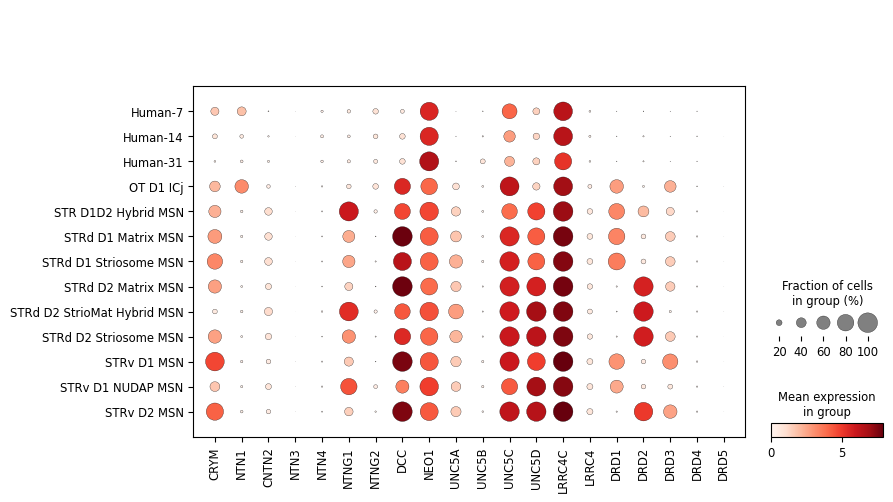

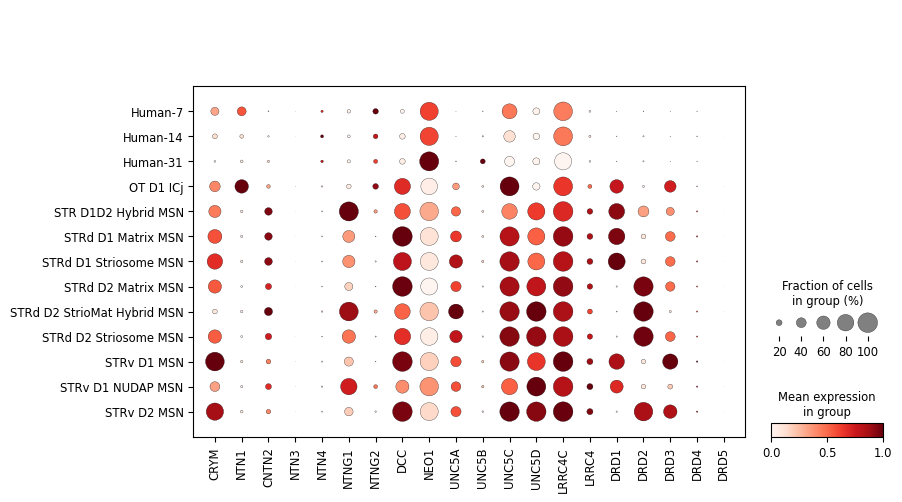

In [9]:
Netrin_genes = ['CRYM', 'NTN1', 'CNTN2', 'NTN3', 'NTN4', 'NTNG1', 'NTNG2', 'DCC', 'NEO1', 'UNC5A', 'UNC5B', 'UNC5C', 'UNC5D', 'LRRC4C', 'LRRC4', 'DRD1', 'DRD2', 'DRD3', 'DRD4', 'DRD5']

sc.pl.dotplot(adata, 
              Netrin_genes, 
              groupby='Ident_notes2', 
              standard_scale=None,#'var',
              use_raw=False, 
              swap_axes=False,           
            #  save="astro_marker_heatmap.pdf" 
) 

sc.pl.dotplot(adata, 
              Netrin_genes, 
              groupby='Ident_notes2', 
              standard_scale='var',
              use_raw=False, 
              swap_axes=False,           
            #  save="astro_marker_heatmap.pdf" 
) 

In [12]:
group_order = ['Human-7', 'Human-14', 'Human-31',
               'STRv D1 MSN', 'STRv D2 MSN', 'STRd D1 Matrix MSN', 'STRd D2 Matrix MSN', 'STRd D1 Striosome MSN', 'STRd D2 Striosome MSN', 'STRd D2 StrioMat Hybrid MSN', 'STRv D1 NUDAP MSN', 'STR D1D2 Hybrid MSN', 'OT D1 ICj']
adata.obs['Ident_notes2'] = pd.Categorical(adata.obs['Ident_notes2'],
                                              categories=group_order,
                                              ordered=True)

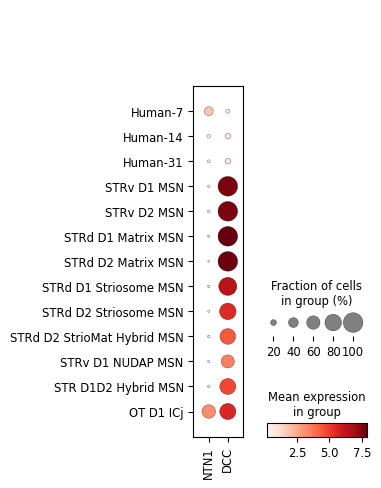

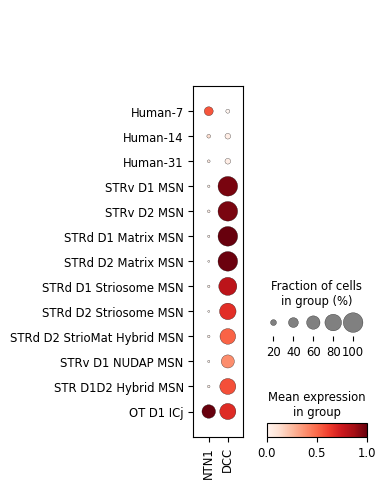

In [16]:
Netrin_genes = ['NTN1', 'DCC'] #'NEO1' everywehre and higher in Astro + lower MSNs.

sc.pl.dotplot(adata, 
              Netrin_genes, 
              groupby='Ident_notes2', 
              standard_scale=None,#'var',
              use_raw=False, 
              swap_axes=False,           
              save="NTN1_DCC_inAstroMSNs.pdf" 
) 

sc.pl.dotplot(adata, 
              Netrin_genes, 
              groupby='Ident_notes2', 
              standard_scale='var',
              use_raw=False, 
              swap_axes=False,           
            #  save="astro_marker_heatmap.pdf" 
) 

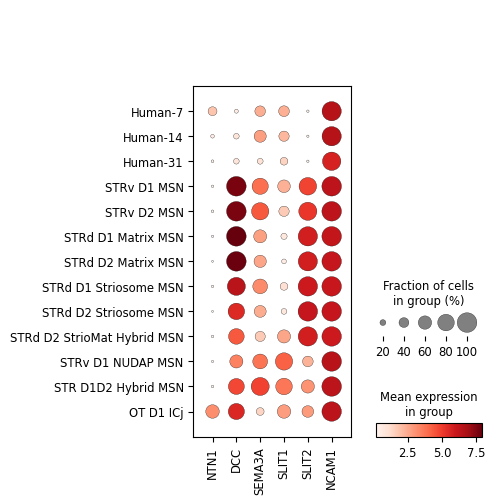

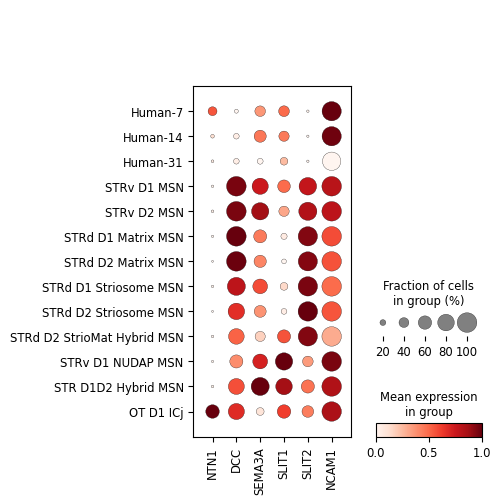

In [17]:
Netrin_genes = ['NTN1', 'DCC', 'SEMA3A', 'SLIT1', 'SLIT2', 'NCAM1'] #'NEO1' everywehre and higher in Astro + lower MSNs.

sc.pl.dotplot(adata, 
              Netrin_genes, 
              groupby='Ident_notes2', 
              standard_scale=None,#'var',
              use_raw=False, 
              swap_axes=False,           
           #   save="NTN1_DCC_inAstroMSNs.pdf" 
) 


### Siletti - subcluster_id of NAC enriched

In [20]:
adata = sc.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/hct_ux3_cellxgene/anndata_080/BasalGanglia/Astro/../Siletti/astro_norm.h5ad")

In [21]:
adata_c55 = adata[adata.obs['cluster_id'].isin([55])].copy()
adata_c55

AnnData object with n_obs × n_vars = 3576 × 59236
    obs: 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'supercluster_term', 'cluster_id', 'subcluster_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'feature_label'
    uns: 'batch_condition', 'citation', 'log1p', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_UMAP', 'X_tSNE'

In [22]:
adata_c55.obs['subcluster_id'].value_counts()

subcluster_id
3083    1162
3081    1126
3082     814
3084     327
3075     127
3092      20
Name: count, dtype: int64

In [23]:
adata_c55.obs['roi'] = adata_c55.obs['roi'].str.replace(r'^Human', '', regex=True)
adata_c55.obs['roi'] = adata_c55.obs['roi'].str.strip()

In [29]:
region = 'roi'
counts = (
    adata_c55.obs
    .groupby(['subcluster_id', region])
    .size()
    .rename('count')
    .reset_index()
)

# 2) proportions within each subcluster_id  ✅ transform keeps original index
counts['prop'] = counts['count'] / counts.groupby('subcluster_id')['count'].transform('sum')

# (optional) ordering
sub_order = counts['subcluster_id'].unique().tolist()
dissect_order = sorted(counts[region].unique().tolist())

# 3) pivot to wide for stacked bar
pivot_prop = (
    counts.pivot_table(index='subcluster_id', columns=region,
                       values='prop', fill_value=0.0)
    .reindex(index=sub_order, columns=dissect_order)
)

#ax = pivot_prop.plot(kind='bar', stacked=True, figsize=(9, 9))
#ax.set_ylabel('Proportion')
#ax.set_xlabel('subcluster_id')
#ax.set_title('Dissection composition per subcluster_id')
#ax.legend(title=region, bbox_to_anchor=(1.02, 1), loc='upper left')

#plt.tight_layout()
#plt.show()

/scratch/fast/3085120/ipykernel_2379140/4119574056.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_b = plt.cm.get_cmap("tab20b")
/scratch/fast/3085120/ipykernel_2379140/4119574056.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_c = plt.cm.get_cmap("tab20c")


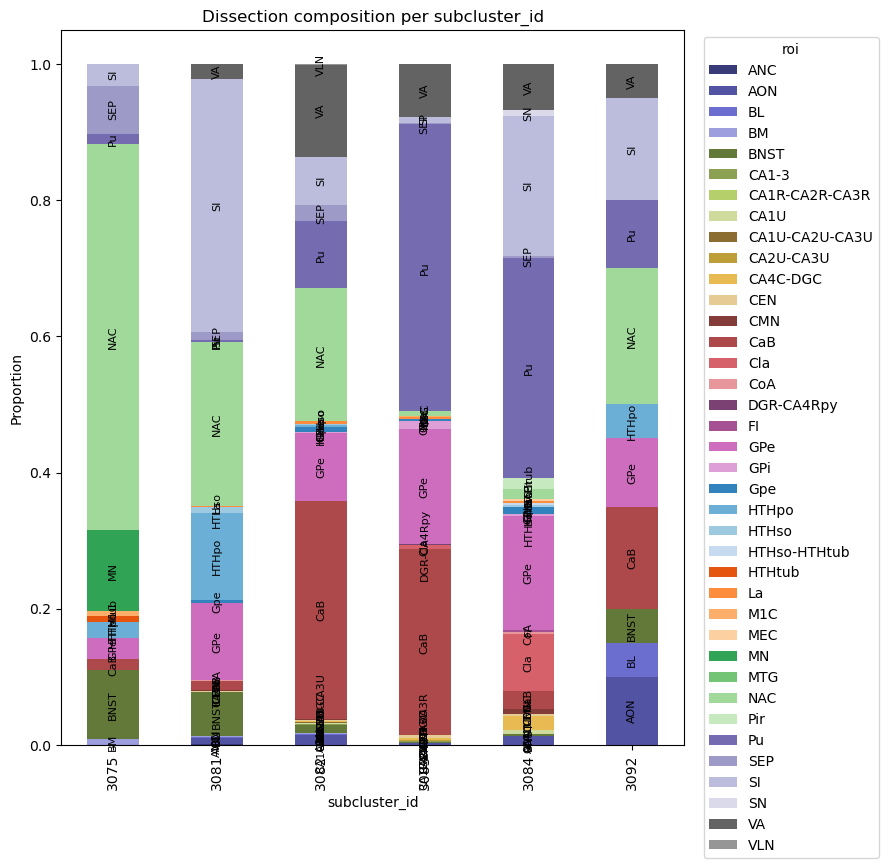

In [41]:
import matplotlib.pyplot as plt

def get_tab20bc_palette():
    """
    Combine tab20b and tab20c into a 40-color palette
    (8 families × 5 colors each).
    """
    cmap_b = plt.cm.get_cmap("tab20b")
    cmap_c = plt.cm.get_cmap("tab20c")

    colors_b = [cmap_b(i) for i in range(cmap_b.N)]  # 20 colors
    colors_c = [cmap_c(i) for i in range(cmap_c.N)]  # 20 colors

    return colors_b + colors_c   # 40 colors total

# get color palette
colors = get_tab20bc_palette()

# draw
ax = pivot_prop.plot(
    kind="bar", stacked=True, figsize=(9, 9),
    color=colors[:len(pivot_prop.columns)]  
)

ax.set_ylabel('Proportion')
ax.set_xlabel('subcluster_id')
ax.set_title('Dissection composition per subcluster_id')
ax.legend(title=region, bbox_to_anchor=(1.02, 1), loc='upper left')

for idx, (sub_id, row) in enumerate(pivot_prop.iterrows()):
    cum_height = 0
    for col in pivot_prop.columns:
        value = row[col]
        if value > 0:  
            ax.text(
                idx,                          
                cum_height + value / 2,       
                f"{col}",                    
                ha='center', va='center', fontsize=8, rotation=90
            )
        cum_height += value

plt.tight_layout()
plt.savefig("Siletti_c55_subcluster-id_dissection_composition.pdf")
plt.show()


Matched gene IDs: ['NTN1_ENSG00000065320', 'DCHS2_ENSG00000197410', 'CRYM_ENSG00000103316']


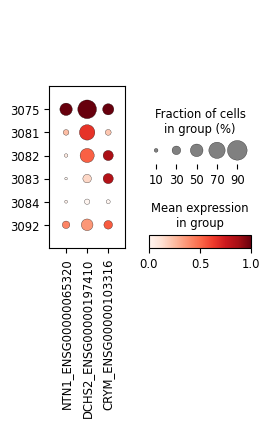

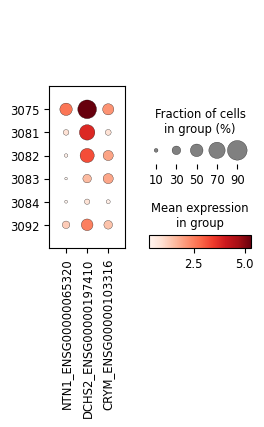

In [27]:
genes = ['NTN1', 'DCHS2','CRYM'] # 'NTNG1', 'GFAP'

all_varnames = adata_c55.var_names.astype(str).tolist()

matched_genes = []

for g in genes:
    matches = [v for v in all_varnames if v.startswith(g + "_")]
    if matches:
        matched_genes.append(matches[0]) 
    else:
        print(f"Warning: {g} not found")
print("Matched gene IDs:", matched_genes)


sc.pl.dotplot(adata_c55, 
              matched_genes, 
              groupby='subcluster_id', 
              standard_scale='var',
              use_raw=False, 
              swap_axes=False,   
              save="Siletti_NTN1_DCHS2_CRYM-dotplot.pdf"
) 

sc.pl.dotplot(adata_c55, 
              matched_genes, 
              groupby='subcluster_id', 
              standard_scale=None,
              use_raw=False, 
              swap_axes=False,           
) 

### DRD1/2/3/4/5 across astrocyte clusters

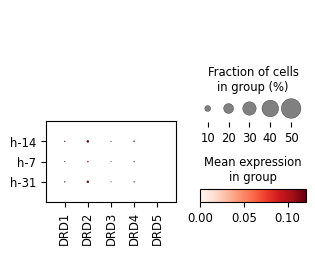

In [50]:
marker_to_show=['DRD1', 'DRD2', 'DRD3', 'DRD4', 'DRD5']
sc.pl.dotplot(
    adata_str, ##shown in not-down-sampled h5ad, although DEGs calculated against d.s.
    marker_to_show,
    groupby='cluster',
    use_raw=False,
    standard_scale=None,#'var',
    #figsize=(2.5, 2),
    dot_max=0.5,
    swap_axes=False,
    save="DRDgenes_in_GMSTRastro3clusters.pdf"
)

### TAC3 across MSN groups in each species

In [2]:
adata = sc.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/xspecies/BasalGanglia/HMBA_Human_Macaque_Marmoset_Mouse_snRNA-seq_BG_neuron_alignment_labeltransfer_allgenes.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 1298997 × 15466
    obs: 'Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster', 'cluster_id', 'cell_type_ontology_term', 'load_id', 'donor_id', 'assay', 'assay_ontology_term_id', 'organism', 'organism_ontology_term_id', 'development_stage', 'anatomical_region', 'anatomical_region_merged', 'anatomical_region_ontology_term_id', 'brain_region_ontology_term_id', 'self_reported_sex', 'self_reported_sex_ontology_term_id', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'disease', 'disease_ontology_term_id', 'suspension_type', 'is_primary_data', 'total_counts', 'total_genes', 'doublet_score', 'organism_sci', 'accession_group', 'embedding_set', 'CL:ID_group', 'tokens_group', 'display_order_group', 'literature_support', 'literature_name_short', 'literature_name_long', 'curated_markers', 'color_hex_group', 'color_group', 'accession_subclass', 'CL:ID_subclass', 'tokens_subclass', 'display_order_subclass', 'color_hex_subclass', 'color_s

In [4]:
selected = ["STR D1 MSN", "STR D2 MSN", "STR Hybrid MSN"] #, "OT Granular GABA"
adata_msn = adata[adata.obs["Subclass"].isin(selected)].copy()


In [5]:
adata_msn

AnnData object with n_obs × n_vars = 841005 × 15466
    obs: 'Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster', 'cluster_id', 'cell_type_ontology_term', 'load_id', 'donor_id', 'assay', 'assay_ontology_term_id', 'organism', 'organism_ontology_term_id', 'development_stage', 'anatomical_region', 'anatomical_region_merged', 'anatomical_region_ontology_term_id', 'brain_region_ontology_term_id', 'self_reported_sex', 'self_reported_sex_ontology_term_id', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'disease', 'disease_ontology_term_id', 'suspension_type', 'is_primary_data', 'total_counts', 'total_genes', 'doublet_score', 'organism_sci', 'accession_group', 'embedding_set', 'CL:ID_group', 'tokens_group', 'display_order_group', 'literature_support', 'literature_name_short', 'literature_name_long', 'curated_markers', 'color_hex_group', 'color_group', 'accession_subclass', 'CL:ID_subclass', 'tokens_subclass', 'display_order_subclass', 'color_hex_subclass', 'color_su

In [6]:
adata_msn_3species = adata_msn[~adata_msn.obs['organism'].isna()].copy()

In [7]:
from scipy import sparse

def dotplot_gene_by_species_cluster(
    adata,
    gene,
    species_key="organism",
    cluster_key="Cluster",
    layer=None,                  # e.g. "log1p", "counts", or None -> use .X
    size_max=600,                # max dot area
    cmap="viridis",
    save_pdf=None                # e.g. "gene_pattern.pdf" or None
):
    """
    Make a dot plot for a single gene across (species x cluster).
    X-axis: species; Y-axis: cluster.
    Dot color = mean expression, dot size = fraction of cells > 0.
    """

    # ----- 0) Resolve expression matrix -----
    def get_matrix(A, lyr):
        if lyr is None:
            X = A.X
        else:
            if lyr not in (A.layers.keys()):
                raise ValueError(f"Layer '{lyr}' not found in adata.layers.")
            X = A.layers[lyr]
        # return dense float array for slicing
        if sparse.issparse(X):
            X = X.toarray()
        return np.asarray(X, dtype=float)

    # choose where the gene lives (var or raw)
    if gene in adata.var_names:
        Aexp = adata
        var_idx = int(np.where(adata.var_names == gene)[0][0])
    elif adata.raw is not None and gene in adata.raw.var_names:
        Aexp = adata.raw.to_adata()
        var_idx = int(np.where(Aexp.var_names == gene)[0][0])
    else:
        raise ValueError(f"Gene '{gene}' not found in adata.var_names or adata.raw.var_names.")

    X = get_matrix(Aexp, layer)

    # ----- 1) Order of axes -----
    # Use categorical order if available, else sorted unique
    def ordered_cats(series):
        if pd.api.types.is_categorical_dtype(series):
            return list(series.cat.categories)
        return sorted(series.unique())

    species = ordered_cats(adata.obs[species_key])
    clusters = ordered_cats(adata.obs[cluster_key])

    # ----- 2) Compute mean & %>0 for each (cluster, species) -----
    mean_mat = np.full((len(clusters), len(species)), np.nan, dtype=float)
    pct_mat  = np.full((len(clusters), len(species)), np.nan, dtype=float)

    for i, cl in enumerate(clusters):
        mask_cl = (adata.obs[cluster_key] == cl).values
        for j, sp in enumerate(species):
            mask_sp = (adata.obs[species_key] == sp).values
            mask = mask_cl & mask_sp
            n = int(mask.sum())
            if n == 0:
                continue
            vals = X[mask, var_idx]
            mean_mat[i, j] = float(vals.mean())
            pct_mat[i, j]  = float((vals > 0).sum() / n)

    # Handle case with no data at all
    if np.all(np.isnan(mean_mat)):
        raise RuntimeError("No cells for any (species, cluster) combination.")

    # Replace NaNs in pct with 0 for plotting size
    pct_plot = np.nan_to_num(pct_mat, nan=0.0)

    # ----- 3) Build dot plot -----
    fig, ax = plt.subplots(figsize=(1.6*len(species) + 1.5, 0.45*len(clusters) + 2.5))

    # Grid of points
    xs = np.arange(len(species))
    ys = np.arange(len(clusters))
    XX, YY = np.meshgrid(xs, ys)

    # Flatten for scatter
    x_flat = XX.ravel()
    y_flat = YY.ravel()
    mean_flat = mean_mat.ravel()
    pct_flat  = pct_plot.ravel()

    # Normalize sizes to [0, size_max]
    sizes = pct_flat * size_max

    sc = ax.scatter(
        x_flat, y_flat,
        s=sizes,
        c=mean_flat,
        cmap=cmap,
        edgecolors="none"
    )

    # Axis labels & ticks
    ax.set_xticks(xs)
    ax.set_xticklabels(species, rotation=0)
    ax.set_yticks(ys)
    ax.set_yticklabels(clusters)
    ax.set_xlim(-0.5, len(species)-0.5)
    ax.set_ylim(-0.5, len(clusters)-0.5)
    ax.invert_yaxis()  # top = first cluster
    ax.set_xlabel(species_key)
    ax.set_ylabel(cluster_key)
    ax.set_title(f"Expression pattern of {gene}")

    # Colorbar (mean expression)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label("Mean expression")

    # Size legend (% expressing)
    for frac in [0.25, 0.5, 0.75, 1.0]:
        ax.scatter([], [], s=frac*size_max, c="gray", alpha=0.7, edgecolors="none",
                   label=f"{int(frac*100)}%")
    leg = ax.legend(
        scatterpoints=1,
        labelspacing=0.6,
        title="% cells > 0",
        frameon=False,
        loc="upper right",
        bbox_to_anchor=(1.25, 1.0)
    )

    plt.tight_layout()

    if save_pdf:
        plt.savefig(save_pdf, format="pdf", bbox_inches="tight", dpi=300)

    plt.show()



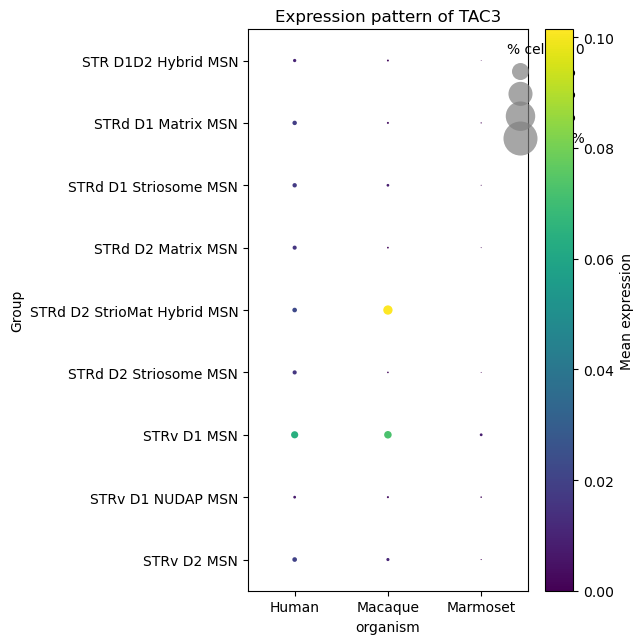

In [8]:
dotplot_gene_by_species_cluster(adata_msn_3species, gene="TAC3", species_key="organism", cluster_key="Group",
                                layer=None, size_max=600, cmap="viridis",
                                 save_pdf="TAC3_species_MSNsGro_dotplot.pdf")


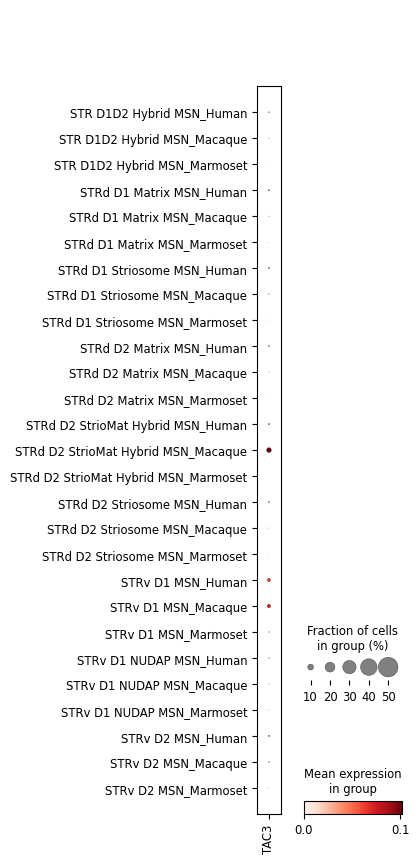

In [11]:
sc.pl.dotplot(
    adata_msn_3species, ##shown in not-down-sampled h5ad, although DEGs calculated against d.s.
    ['TAC3'],
    groupby=['Group','organism'],
    use_raw=False,
    standard_scale=None,#'var',
    #figsize=(2.5, 2),
    dot_max=0.5,
    swap_axes=False,
   # save="DRDgenes_in_GMSTRastro3clusters.pdf"
)

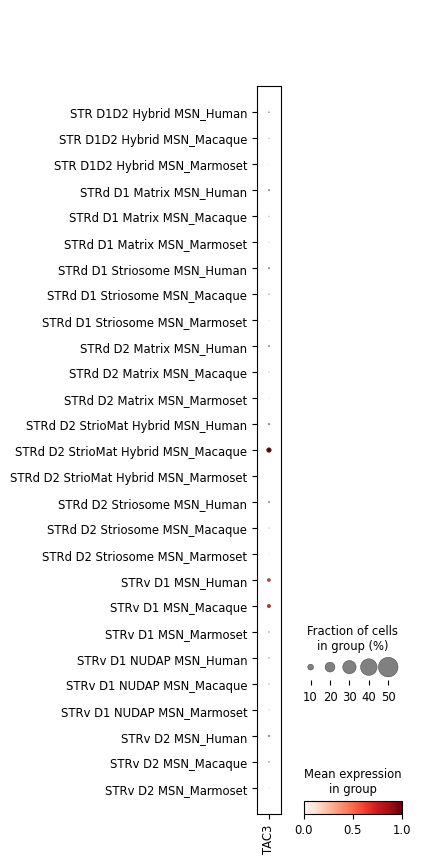

In [12]:
sc.pl.dotplot(
    adata_msn_3species, ##shown in not-down-sampled h5ad, although DEGs calculated against d.s.
    ['TAC3'],
    groupby=['Group','organism'],
    use_raw=False,
    standard_scale='var',#'var',
    #figsize=(2.5, 2),
    dot_max=0.5,
    swap_axes=False,
   # save="DRDgenes_in_GMSTRastro3clusters.pdf"
)

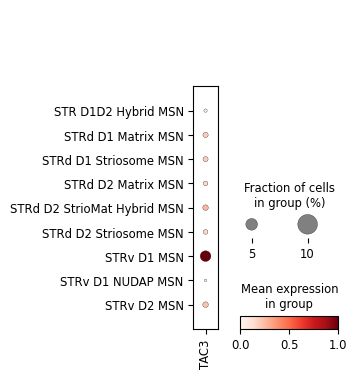

In [16]:

sc.pl.dotplot(
    adata_msn_3species[adata_msn_3species.obs['organism'] == "Human"], ##shown in not-down-sampled h5ad, although DEGs calculated against d.s.
    ['TAC3'],
    groupby=['Group'],
    use_raw=False,
    standard_scale='var',#'var',
    #figsize=(2.5, 2),
    #dot_max=0.2,
    swap_axes=False,
    save="TAC3_inSNrna_humanMSNs.pdf"
)

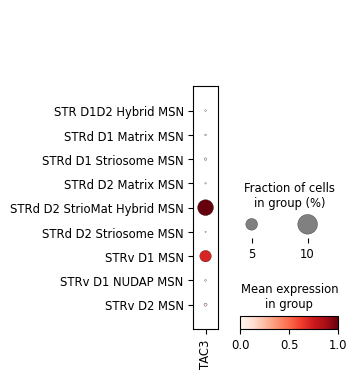

In [17]:

sc.pl.dotplot(
    adata_msn_3species[adata_msn_3species.obs['organism'] == "Macaque"], ##shown in not-down-sampled h5ad, although DEGs calculated against d.s.
    ['TAC3'],
    groupby=['Group'],
    use_raw=False,
    standard_scale='var',#'var',
    #figsize=(2.5, 2),
    #dot_max=0.5,
    swap_axes=False,
   # save="DRDgenes_in_GMSTRastro3clusters.pdf"
)

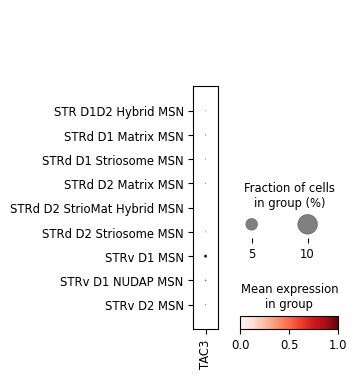

In [19]:

sc.pl.dotplot(
    adata_msn_3species[adata_msn_3species.obs['organism'] == "Marmoset"], ##shown in not-down-sampled h5ad, although DEGs calculated against d.s.
    ['TAC3'],
    groupby=['Group'],
    use_raw=False,
    standard_scale='var',#'var',
    #figsize=(2.5, 2),
    #dot_max=0.5,
    swap_axes=False,
   # save="DRDgenes_in_GMSTRastro3clusters.pdf"
)

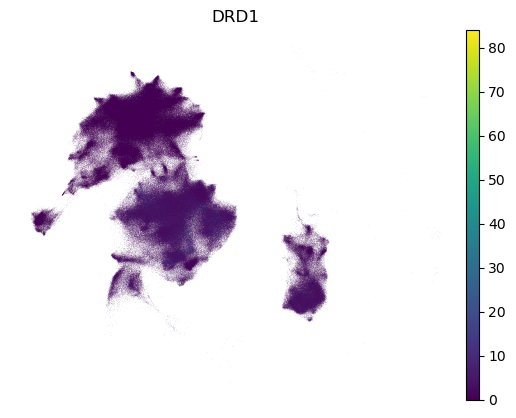

In [23]:
sc.pl.embedding(
    adata_msn_3species,
    basis="X_umap",
    color=['DRD1'],
    frameon=False,
)

In [24]:
sc.pp.normalize_total(adata_msn_3species, target_sum=1e6)
sc.pp.log1p(adata_msn_3species)

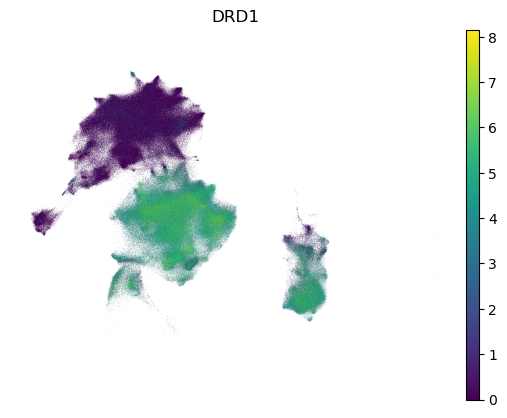

In [25]:
sc.pl.embedding(
    adata_msn_3species,
    basis="X_umap",
    color=['DRD1'],
    frameon=False,
)

In [26]:
group_order = ['STRv D1 MSN', 'STRd D1 Striosome MSN', 'STRd D1 Matrix MSN', 'STRv D2 MSN', 'STRd D2 Striosome MSN', 'STRd D2 Matrix MSN', 'STRd D2 StrioMat Hybrid MSN', 'STR D1D2 Hybrid MSN', 'STRv D1 NUDAP MSN']
adata_msn_3species.obs['Group'] = pd.Categorical(adata_msn_3species.obs['Group'],
                                          categories=group_order,
                                          ordered=True)

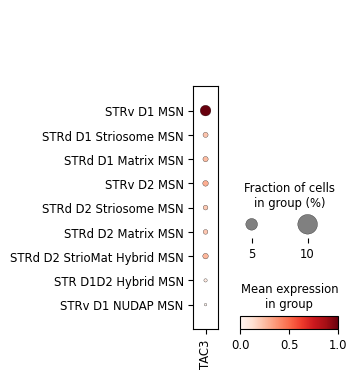

In [27]:
sc.pl.dotplot(
    adata_msn_3species[adata_msn_3species.obs['organism'] == "Human"], ##shown in not-down-sampled h5ad, although DEGs calculated against d.s.
    ['TAC3'],
    groupby=['Group'],
    use_raw=False,
    standard_scale='var',#'var',
    dot_max=0.1,
    swap_axes=False,
    save="TAC3_in_humanMSNs_snRNAseqData.pdf"
)


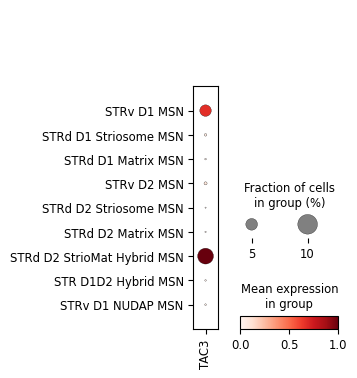

In [28]:
sc.pl.dotplot(
    adata_msn_3species[adata_msn_3species.obs['organism'] == "Macaque"], ##shown in not-down-sampled h5ad, although DEGs calculated against d.s.
    ['TAC3'],
    groupby=['Group'],
    use_raw=False,
    standard_scale='var',#'var',
    dot_max=0.1,
    swap_axes=False,
    save="TAC3_in_macaqueMSNs_snRNAseqData.pdf"
)


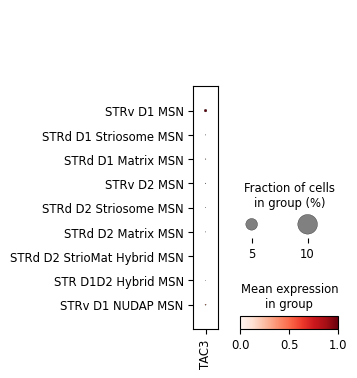

In [29]:
sc.pl.dotplot(
    adata_msn_3species[adata_msn_3species.obs['organism'] == "Marmoset"], ##shown in not-down-sampled h5ad, although DEGs calculated against d.s.
    ['TAC3'],
    groupby=['Group'],
    use_raw=False,
    standard_scale='var',#'var',
    dot_max=0.1,
    swap_axes=False,
    save="TAC3_in_marmosetMSNs_snRNAseqData.pdf"
)
